In [1]:
from PIL import Image
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor, BlipProcessor, BlipForConditionalGeneration, pipeline
from qwen_vl_utils import process_vision_info
import gradio as gr
import zipfile
import os
import numpy as np
import random
import shutil
import pandas as pd
import cv2
from qwen import extract_zip_path, generate_random_sample, read_blue_channel

c:\Users\archi\anaconda3\envs\asid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\archi\anaconda3\envs\asid\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\archi\anaconda3\envs\asid\lib\site-packages\torchvision\transfo

In [2]:
# Zipfile path containing data
zipfile_path = os.path.expanduser("~") + '\\ecdna-analysis\\data\\ecSeg_dataset.zip'
zipfile_path

'C:\\Users\\archi\\ecdna-analysis\\data\\ecSeg_dataset.zip'

In [3]:
zip_file_path = 'C:\\Users\\archi\\ecdna-analysis\\data\\ecSeg_dataset.zip'
folder_name = 'test_im/'
extract_folder = 'test_im_images'
extract_zip_path(zip_file_path, folder_name, extract_folder)

In [4]:
input_folder = 'C:/Users/archi/ecdna-analysis/blip/test_im_images/ecSeg_dataset/test_im'
output_folder = 'C:/Users/archi/ecdna-analysis/sampled'
generate_random_sample(input_folder, output_folder)

,0
0,858.tif
1,2231.tif
2,371.tif
3,370.tif
4,591.tif
...,...
195,314.tif
196,712.tif
197,398.tif
198,2069.tif


In [5]:
images = [f for f in os.listdir(output_folder)]
len(images)

200

In [6]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)


cuda


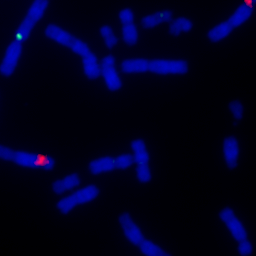

In [8]:
img_num = 2510
img_path = f'C:\\Users\\archi\\ecdna-analysis\\blip\\train_im_images\\ecSeg_dataset\\train_im\\{str(img_num)}.tif'
Image.open(img_path)

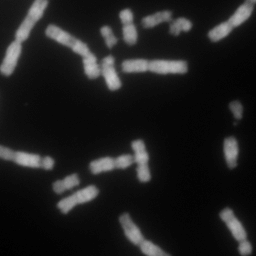

In [9]:
read_blue_channel(img_path)

In [10]:
# read_blue_channel(img_path)

In [11]:
system_message = "You are a pathologist studying metaphase cell images. The images are stained with DAPI 4' 6'' and these images contain various biological structures."
questionsList = [
    
    "How many nuclei, chromosomes, and ecDNA are in the image? Provide count for each and format the data as json."
]
textPrompt = system_message + ' ' + ' '.join(questionsList)
img = read_blue_channel(img_path)
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": img
            },
            {"type": "text", "text": textPrompt},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, _ = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=120)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

with open('C:/Users/archi/ecdna-analysis/blip/response.txt', 'w') as f:
    f.write(output_text)


In [12]:
output_text

"To determine the number of nuclei, chromosomes, and ecDNA in the image, we need more information about the specific staining and staining conditions used. However, I can provide a general approach to counting these structures based on common staining techniques.\n\n1. **Nuclei**: These are the central structures in the cell, often stained with DAPI (4',6-diamidino-2-phenylindole) to visualize DNA. The nuclei are typically round or oval in shape and can be counted by eye or using image analysis software.\n\n2. **Chromosomes**: Chromosomes are the"

In [13]:
model.get_parameter

<bound method Module.get_parameter of Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, element